In [153]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [347]:
from data import load_data

vids = ['blxV8_0phjI', 'I5eUYtacGWE', 'c7lFZD6pN2E', 'AkOIdLpi150', 'Nw8CslfQl78', 'ugJ-rYS-9JU']
data = load_data(vids)

[youtube] blxV8_0phjI: Downloading webpage
[download] Destination: data/blxV8_0phjI.webm
[download] 100% of 1.31MiB in 00:2550KiB/s ETA 00:00
[ffmpeg] Destination: data/blxV8_0phjI.wav
Deleting original file data/blxV8_0phjI.webm (pass -k to keep)


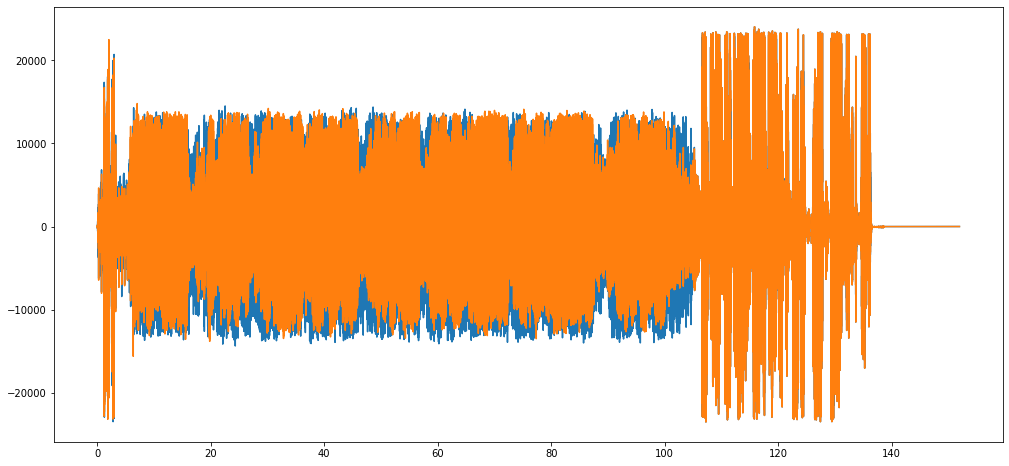

In [407]:
d = data[-1]

x, t = d.data, d.time
l, r = x[:, 0], x[:, 1]

plt.figure(figsize=(17, 8))
plt.plot(t, l)
plt.plot(t, r);

Let's FFT

In [408]:
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hann, tukey, blackmanharris
from scipy.signal import savgol_filter

from matplotlib.animation import FuncAnimation

Get some curves?

In [418]:
t_window = 0.1 # seconds
n_window = int(t_window*d.fs) # samples

t_start, t_end = 20, 80
i_start, i_end = int(t_start*d.fs), int(t_end*d.fs)
i_window = np.arange(i_start, i_end, n_window)

# x-axis
xf = fftfreq(n_window, d.dt)[:n_window//2]

# Set frequency limits
f_min, f_max = 250, 7500
mask = (xf >= f_min) & (xf <= f_max)
xf = xf[mask]

w = hann(n_window)
def process(signal, i):
    f = fft(w*signal[i:i + n_window])
    mag = np.abs(f[:n_window//2])[mask]
    return mag

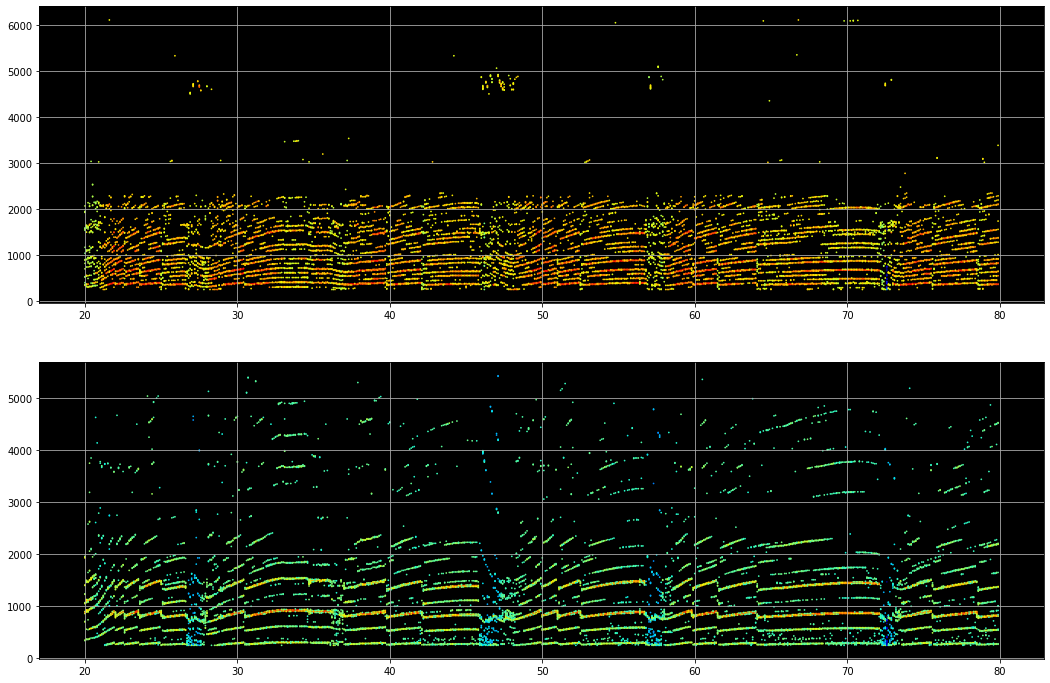

In [421]:
N = 20
def top_n(signal):
    return signal.argsort()[-N:][::-1]

# Really quick get maxima
mls, mrs = [], []
mls_v, mrs_v = [], []
for i in i_window:
    fl, fr = process(l, i), process(r, i)

    if fl.max() == 0 or fr.max() == 0:
        mls.append(mls[-1]), mrs.append(mrs[-1])
        mls_v.append(mls_v[-1]), mrs_v.append(mrs_v[-1])
    else:
        mls.append(top_n(fl)), mrs.append(top_n(fr))
        mls_v.append(fl[mls[-1]]), mrs_v.append(fr[mrs[-1]])

mls_v, mrs_v = np.array(mls_v), np.array(mrs_v)
mls_v, mrs_v = np.log10(mls_v/mls_v.max()), np.log10(mrs_v/mrs_v.max())

hi_l, hi_r = mls_v.max(), mrs_v.max()
lo_l, lo_r = mls_v.min(), mrs_v.min()

fig, (ax_l, ax_r) = plt.subplots(nrows=2, figsize=(18, 12))

import matplotlib
colors = matplotlib.cm.jet(np.linspace(0, 1, i_window.shape[0] + 1))

for i in range(N):
    cs = colors[(((mls_v[:, i] - lo_l)/(hi_l - lo_l))*i_window.shape[0]).astype(int)]
    ax_l.scatter(i_window*d.dt, [xf[ml[i]] for ml in mls], color=cs, s=0.5)

    cs = colors[(((mrs_v[:, i] - lo_r)/(hi_r - lo_r))*i_window.shape[0]).astype(int)]
    ax_r.scatter(i_window*d.dt, [xf[mr[i]] for mr in mrs], color=cs, s=0.5)

ax_l.grid()
ax_r.grid()

ax_l.set_facecolor('black')
ax_r.set_facecolor('black')

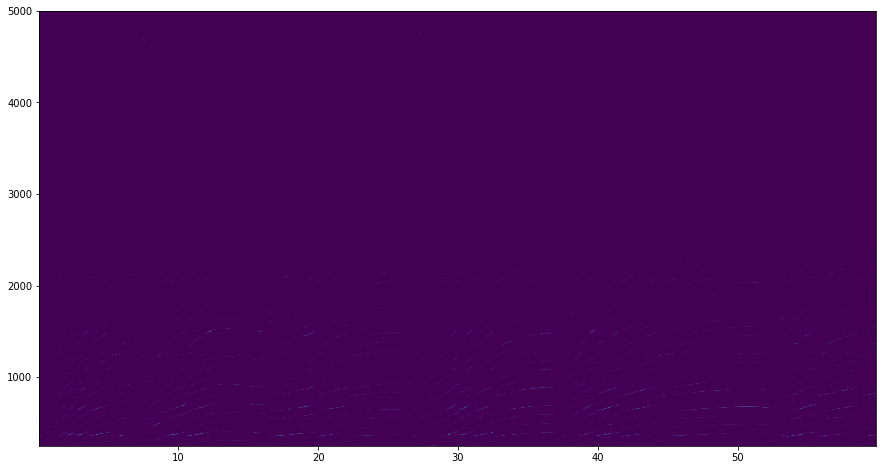

In [411]:
# Try built-in
from scipy.signal import spectrogram

plt.figure(figsize=(15, 8))

f, t, S = spectrogram(l[i_start:i_end], fs=d.fs, nperseg=10000, noverlap=5000)
plt.pcolormesh(t, f, S)
plt.ylim([f_min, f_max]);